In [ ]:
# Passo 1: Instalação de Bibliotecas Necessárias
!pip install -U transformers datasets trl peft accelerate bitsandbytes scikit-learn rouge-score nltk bert-score huggingface_hub tensorboard tqdm seaborn matplotlib pandas torch evaluate openai==0.28

In [ ]:
# Passo 2: Importação das Bibliotecas
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, PeftConfig
from trl import SFTTrainer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
import nltk
import numpy as np
from huggingface_hub import notebook_login
from tensorboard import notebook
from bert_score import score as bertscore
from tqdm import tqdm
import locale
import random
import evaluate
import openai

In [ ]:
# Passo 3: Download de Recursos do NLTK
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Passo 4: Autenticação no Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
# Passo 5: Carregamento do Tokenizador
base_model_name = "meta-llama/Llama-2-7b-hf"  # Nome do modelo base

# Carregar o tokenizador
tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)

# Definir o token de padding
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# Passo 6: Configuração de Quantização com BitsAndBytes
from transformers import BitsAndBytesConfig

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Carregar modelo em 4-bit
    bnb_4bit_quant_type="nf4",             # Tipo de quantização
    bnb_4bit_compute_dtype=torch.float16,  # Tipo de dado para cálculos
    bnb_4bit_use_double_quant=False,       # Não usar dupla quantização
)


In [ ]:
# Passo 7: Carregamento do Modelo Base com Quantização
from transformers import AutoModelForCausalLM

base_model = "meta-llama/Llama-2-7b-hf"

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map="auto",        # Mapeamento automático de dispositivos
    trust_remote_code=True,   # Necessário para alguns modelos que usam código personalizado
)
model.config.use_cache = False  # Desativar cache para economizar memória


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
# Passo 8: Carregamento do Modelo PEFT (LoRA)
peft_model_name = "guilhermemoraisr/sofascore-multitask"  # Nome do modelo PEFT

# Carregar a configuração PEFT
peft_config = PeftConfig.from_pretrained(peft_model_name)

# Carregar o modelo ajustado com PEFT
model = PeftModel.from_pretrained(model, peft_model_name)


adapter_config.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

In [ ]:
# Passo 9: Configuração do Pipeline de Geração de Texto
from transformers import pipeline

# Configuração do pipeline de geração de texto
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    #device=0 if torch.cuda.is_available() else -1,  # Usa GPU se disponível, senão CPU
    max_new_tokens=150,                            # Número máximo de tokens a serem gerados
    temperature=0.7,                                # Controla a aleatoriedade das previsões
    top_p=0.9,                                      # Filtra os tokens de acordo com a probabilidade acumulada
    do_sample=True,                                 # Ativa a amostragem para gerar respostas mais diversificadas
)


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCaus

In [ ]:
# # Passo 10: Função para Gerar Respostas
# def generate_response(prompt, max_new_tokens=150):
#     """
#     Gera uma resposta para um dado prompt usando o pipeline configurado.

#     Args:
#         prompt (str): A instrução ou pergunta para o modelo.
#         max_new_tokens (int): Número máximo de tokens a serem gerados na resposta.

#     Returns:
#         str: A resposta gerada pelo modelo.
#     """
#     response = text_generator(prompt, max_new_tokens=max_new_tokens)
#     return response[0]['generated_text'][len(prompt):].strip()


In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StopOnTokens(StoppingCriteria):
    def __init__(self, stop_token_ids):
        self.stop_token_ids = stop_token_ids

    def __call__(self, input_ids, scores, **kwargs):
        # Verifica se os últimos tokens correspondem à sequência de parada
        if len(input_ids[0]) >= len(self.stop_token_ids):
            if (input_ids[0][-len(self.stop_token_ids):] == self.stop_token_ids).all():
                return True
        return False

In [ ]:
# Passo 8: Função para Gerar Respostas com Stopping Criteria
def generate_response_with_stop(prompt, max_new_tokens=150, stop_sequence="### Instruction:"):
    """
    Gera uma resposta para um dado prompt usando o modelo com Stopping Criteria.

    Args:
        prompt (str): A instrução ou pergunta para o modelo.
        max_new_tokens (int): Número máximo de tokens a serem gerados na resposta.
        stop_sequence (str): Sequência que, ao ser gerada, interrompe a geração.

    Returns:
        str: A resposta gerada pelo modelo.
    """
    # Codificar o prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(model.device)

    # Codificar a sequência de parada
    stop_token_ids = tokenizer.encode(stop_sequence, add_special_tokens=False)

    # Definir os critérios de parada
    stopping_criteria = StoppingCriteriaList([StopOnTokens(torch.tensor(stop_token_ids).to(model.device))])

    # Gerar a resposta
    generation_output = model.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        stopping_criteria=stopping_criteria,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    # Decodificar a resposta gerada
    generated_text = tokenizer.decode(generation_output[0], skip_special_tokens=True)

    # Extrair apenas a parte gerada após o prompt
    generated = generated_text[len(prompt):].strip()

    # Remover a sequência de parada, se presente
    if stop_sequence in generated:
        generated = generated.split(stop_sequence)[0].strip()

    return generated


In [ ]:
# Passo 9: Exemplos de Uso com Stopping Criteria

# Exemplo 1
prompt1 = """### Instruction:
In the match between Criciúma and Bahia, Jonathan, a defender from Criciúma, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. On the other hand, Víctor Cuesta, a defender from Bahia, had the following stats: Totaltackle: 2, Totalclearance: 2, Interceptionwon: 3. Based on these statistics, who had a better performance?

### Response:"""

response1 = generate_response_with_stop(prompt1)
print(f"Resposta Gerada:\n{response1}\n")

# Exemplo 2
prompt2 = """### Instruction:
In the match between Flamengo and Cruzeiro, David Luiz, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 2, Interceptionwon: 1. On the other hand, Ayrton Lucas, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. Based on these statistics, who had a better performance?

### Response:"""

response2 = generate_response_with_stop(prompt2)
print(f"Resposta Gerada:\n{response2}\n")

# Exemplo 3
prompt3 = """### Instruction:
In the match between Palmeiras and Internacional, Bruno Henrique, a midfield from Internacional, had the following stats: Accuratepass:
 17, Keypass: 1, Goalassist: 0. On the other hand, Maurício, a midfield from Internacional, had the following stats: Accuratepass: 25, Keypass: 1, Goalassist: 0. Based on these statistics, who had a better performance?

### Response:"""

response3 = generate_response_with_stop(prompt3)
print(f"Resposta Gerada:\n{response3}\n")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Resposta Gerada:
Víctor Cuesta had a better performance.

Resposta Gerada:
David Luiz had a better performance.

Resposta Gerada:
Maurício had a better performance.



In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# Passo 4: Carregamento dos Datasets
df_player_comparison = pd.read_csv('player_comparison_dataset.csv', sep=';')
df_player_performance = pd.read_csv('player_performance_analysis_dataset.csv', sep=';')
df_team_performance = pd.read_csv('team_performance_dataset.csv', sep=';')

In [ ]:
# Verificar as dimensões e visualizar algumas linhas
print("Dataset Player Comparison:", df_player_comparison.shape)
print("Primeira Instrução (Player Comparison):", df_player_comparison.loc[0]['Instructions'])
print("Primeira Resposta (Player Comparison):", df_player_comparison.loc[0]['Responses'])
display(df_player_comparison.head())

Dataset Player Comparison: (11541, 2)
Primeira Instrução (Player Comparison): In the match between Fortaleza and Bahia, Emanuel Brítez, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 1, Interceptionwon: 3. On the other hand, Benjamin Kuscevic, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 5, Interceptionwon: 1. Based on these statistics, who had a better performance?
Primeira Resposta (Player Comparison): Benjamin Kuscevic had a better performance.


,Instructions,Responses
0,"In the match between Fortaleza and Bahia, Emanuel Brítez, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 1, Interceptionwon: 3. On the other hand, Benjamin Kuscevic, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 5, Interceptionwon: 1. Based on these statistics, who had a better performance?",Benjamin Kuscevic had a better performance.
1,"In the match between Fortaleza and Bahia, Emanuel Brítez, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 1, Interceptionwon: 3. On the other hand, Tomás Cardona, a defender from Fortaleza, had the following stats: Totaltackle: 8, Totalclearance: 4, Interceptionwon: 1. Based on these statistics, who had a better performance?",Tomás Cardona had a better performance.
2,"In the match between Fortaleza and Bahia, Emanuel Brítez, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 1, Interceptionwon: 3. On the other hand, Eros Mancuso, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 2, Interceptionwon: 1. Based on these statistics, who had a better performance?",Emanuel Brítez had a better performance.
3,"In the match between Fortaleza and Bahia, Emanuel Brítez, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 1, Interceptionwon: 3. On the other hand, Santiago Arias, a defender from Bahia, had the following stats: Totaltackle: 3, Totalclearance: 1, Interceptionwon: 1. Based on these statistics, who had a better performance?",Santiago Arias had a better performance.
4,"In the match between Fortaleza and Bahia, Emanuel Brítez, a defender from Fortaleza, had the following stats: Totaltackle: 1, Totalclearance: 1, Interceptionwon: 3. On the other hand, Gabriel Xavier, a defender from Bahia, had the following stats: Totaltackle: 1, Totalclearance: 4, Interceptionwon: 3. Based on these statistics, who had a better performance?",Gabriel Xavier had a better performance.


In [ ]:
print("\nDataset Player Performance:", df_player_performance.shape)
print("Primeira Instrução (Player Performance):", df_player_performance.loc[0]['Instructions'])
print("Primeira Resposta (Player Performance):", df_player_performance.loc[0]['Responses'])
display(df_player_performance.head())


Dataset Player Performance: (1557, 2)
Primeira Instrução (Player Performance): In the match between Fortaleza vs Bahia, the player Emanuel Brítez, playing as a defender made 1 tackles, 1 clearances, and 3 interceptions. The average for players in this position was 2.9 tackles, 3.0 clearances, and 1.9 interceptions. Taking this into account, how was his performance?
Primeira Resposta (Player Performance): His performance was good


,Instructions,Responses
0,"In the match between Fortaleza vs Bahia, the player Emanuel Brítez, playing as a defender made 1 tackles, 1 clearances, and 3 interceptions. The average for players in this position was 2.9 tackles, 3.0 clearances, and 1.9 interceptions. Taking this into account, how was his performance?",His performance was good
1,"In the match between Fortaleza vs Bahia, the player Benjamin Kuscevic, playing as a defender made 1 tackles, 5 clearances, and 1 interceptions. The average for players in this position was 2.9 tackles, 3.0 clearances, and 1.9 interceptions. Taking this into account, how was his performance?",His performance was good
2,"In the match between Fortaleza vs Bahia, the player Tomás Cardona, playing as a defender made 8 tackles, 4 clearances, and 1 interceptions. The average for players in this position was 2.9 tackles, 3.0 clearances, and 1.9 interceptions. Taking this into account, how was his performance?",His performance was good
3,"In the match between Fortaleza vs Bahia, the player Eros Mancuso, playing as a defender made 1 tackles, 2 clearances, and 1 interceptions. The average for players in this position was 2.9 tackles, 3.0 clearances, and 1.9 interceptions. Taking this into account, how was his performance?",His performance was bad
4,"In the match between Fortaleza vs Bahia, the player Zé Welison, playing as a midfield had 32 accurate passes, created 1 key chances, and provided 1 assists. The average for players in this position was 29.3 accurate passes, 1.3 key chances, and 1.0 assists. Taking this into account, how was his performance?",His performance was bad


In [ ]:
print("\nDataset Team Performance:", df_team_performance.shape)
print("Primeira Instrução (Team Performance):", df_team_performance.loc[0]['Instructions'])
print("Primeira Resposta (Team Performance):", df_team_performance.loc[0]['Responses'])
display(df_team_performance.head())


Dataset Team Performance: (570, 2)
Primeira Instrução (Team Performance): In the match Fortaleza vs Bahia, the team Fortaleza had 37%% ball possession, 11 total shots, 7 shots on target, pass accuracy of 0%%, 2 corner kicks and committed 13 fouls. How was the team's overall performance?
Primeira Resposta (Team Performance): The Fortaleza had a below-expected performance, with limited ball possession of only 37%%. The team created few goal opportunities, reflected in the 7 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match.


,Instructions,Responses
0,"In the match Fortaleza vs Bahia, the team Fortaleza had 37%% ball possession, 11 total shots, 7 shots on target, pass accuracy of 0%%, 2 corner kicks and committed 13 fouls. How was the team's overall performance?","The Fortaleza had a below-expected performance, with limited ball possession of only 37%%. The team created few goal opportunities, reflected in the 7 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match."
1,"In the match Fortaleza vs Bahia, the team Bahia had 63%% ball possession, 9 total shots, 4 shots on target, pass accuracy of 0%%, 1 corner kicks and committed 9 fouls. How was the team's overall performance?","The Bahia had a below-expected performance, with limited ball possession of only 63%%. The team created few goal opportunities, reflected in the 4 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match."
2,"In the match Atlético Mineiro vs Red Bull Bragantino, the team Atlético Mineiro had 50%% ball possession, 13 total shots, 8 shots on target, pass accuracy of 0%%, 4 corner kicks and committed 14 fouls. How was the team's overall performance?","The Atlético Mineiro had a below-expected performance, with limited ball possession of only 50%%. The team created few goal opportunities, reflected in the 8 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match."
3,"In the match Atlético Mineiro vs Red Bull Bragantino, the team Red Bull Bragantino had 50%% ball possession, 8 total shots, 3 shots on target, pass accuracy of 0%%, 2 corner kicks and committed 9 fouls. How was the team's overall performance?","The Red Bull Bragantino had a below-expected performance, with limited ball possession of only 50%%. The team created few goal opportunities, reflected in the 3 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match."
4,"In the match Vasco vs Palmeiras, the team Vasco had 55%% ball possession, 10 total shots, 3 shots on target, pass accuracy of 0%%, 5 corner kicks and committed 8 fouls. How was the team's overall performance?","The Vasco had a below-expected performance, with limited ball possession of only 55%%. The team created few goal opportunities, reflected in the 3 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match."


In [ ]:
# Passo 5: Seleção Aleatória e Equalização dos Datasets

# Definir o número de amostras por dataset
samples_player_comparison = 1000
samples_player_performance = 1000
samples_team_performance = df_team_performance.shape[0]  # 568

# Verificar se os datasets possuem amostras suficientes
if len(df_player_comparison) < samples_player_comparison:
    print(f"Atenção: O dataset 'player_comparison' possui apenas {len(df_player_comparison)} amostras, menor que {samples_player_comparison}. Será usado o tamanho máximo disponível.")
    samples_player_comparison = len(df_player_comparison)

if len(df_player_performance) < samples_player_performance:
    print(f"Atenção: O dataset 'player_performance' possui apenas {len(df_player_performance)} amostras, menor que {samples_player_performance}. Será usado o tamanho máximo disponível.")
    samples_player_performance = len(df_player_performance)

# Selecionar aleatoriamente as linhas
df_player_comparison_sampled = df_player_comparison.sample(n=samples_player_comparison, random_state=42)
df_player_performance_sampled = df_player_performance.sample(n=samples_player_performance, random_state=42)
df_team_performance_sampled = df_team_performance.sample(n=samples_team_performance, random_state=42)

# Concatenar os DataFrames amostrados
df_combined = pd.concat(
    [df_player_comparison_sampled, df_player_performance_sampled, df_team_performance_sampled],
    ignore_index=True
)

# Verificar o resultado
print("\nDataset Combinado Amostrado:", df_combined.shape)
display(df_combined.head())


Dataset Combinado Amostrado: (2570, 2)


,Instructions,Responses
0,"In the match between Criciúma and Bahia, Jonathan, a defender from Criciúma, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. On the other hand, Víctor Cuesta, a defender from Bahia, had the following stats: Totaltackle: 2, Totalclearance: 2, Interceptionwon: 3. Based on these statistics, who had a better performance?",Víctor Cuesta had a better performance.
1,"In the match between Flamengo and Cruzeiro, David Luiz, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 2, Interceptionwon: 1. On the other hand, Ayrton Lucas, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. Based on these statistics, who had a better performance?",David Luiz had a better performance.
2,"In the match between Red Bull Bragantino and Palmeiras, Eduardo Santos, a defender from Red Bull Bragantino, had the following stats: Totaltackle: 1, Totalclearance: 8, Interceptionwon: 1. On the other hand, Murilo, a defender from Palmeiras, had the following stats: Totaltackle: 2, Totalclearance: 4, Interceptionwon: 1. Based on these statistics, who had a better performance?",Eduardo Santos had a better performance.
3,"In the match between Palmeiras and Internacional, Bruno Henrique, a midfield from Internacional, had the following stats: Accuratepass: 17, Keypass: 1, Goalassist: 0. On the other hand, Maurício, a midfield from Internacional, had the following stats: Accuratepass: 25, Keypass: 1, Goalassist: 0. Based on these statistics, who had a better performance?",Maurício had a better performance.
4,"In the match between Red Bull Bragantino and Fortaleza, Andrés Hurtado, a defender from Red Bull Bragantino, had the following stats: Totaltackle: 0, Totalclearance: 3, Interceptionwon: 1. On the other hand, Tinga, a defender from Fortaleza, had the following stats: Totaltackle: 0, Totalclearance: 4, Interceptionwon: 2. Based on these statistics, who had a better performance?",Tinga had a better performance.


In [ ]:
# Passo 6: Formatação das Instruções e Respostas
df_combined["formatted_instruction"] = df_combined.apply(
    lambda x: f"### Instruction:\n{x['Instructions']}\n\n### Response:\n{x['Responses']}",
    axis=1,
)
display(df_combined.head())

,Instructions,Responses,formatted_instruction
0,"In the match between Criciúma and Bahia, Jonathan, a defender from Criciúma, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. On the other hand, Víctor Cuesta, a defender from Bahia, had the following stats: Totaltackle: 2, Totalclearance: 2, Interceptionwon: 3. Based on these statistics, who had a better performance?",Víctor Cuesta had a better performance.,"### Instruction:\nIn the match between Criciúma and Bahia, Jonathan, a defender from Criciúma, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. On the other hand, Víctor Cuesta, a defender from Bahia, had the following stats: Totaltackle: 2, Totalclearance: 2, Interceptionwon: 3. Based on these statistics, who had a better performance?\n\n### Response:\nVíctor Cuesta had a better performance."
1,"In the match between Flamengo and Cruzeiro, David Luiz, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 2, Interceptionwon: 1. On the other hand, Ayrton Lucas, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. Based on these statistics, who had a better performance?",David Luiz had a better performance.,"### Instruction:\nIn the match between Flamengo and Cruzeiro, David Luiz, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 2, Interceptionwon: 1. On the other hand, Ayrton Lucas, a defender from Flamengo, had the following stats: Totaltackle: 0, Totalclearance: 1, Interceptionwon: 1. Based on these statistics, who had a better performance?\n\n### Response:\nDavid Luiz had a better performance."
2,"In the match between Red Bull Bragantino and Palmeiras, Eduardo Santos, a defender from Red Bull Bragantino, had the following stats: Totaltackle: 1, Totalclearance: 8, Interceptionwon: 1. On the other hand, Murilo, a defender from Palmeiras, had the following stats: Totaltackle: 2, Totalclearance: 4, Interceptionwon: 1. Based on these statistics, who had a better performance?",Eduardo Santos had a better performance.,"### Instruction:\nIn the match between Red Bull Bragantino and Palmeiras, Eduardo Santos, a defender from Red Bull Bragantino, had the following stats: Totaltackle: 1, Totalclearance: 8, Interceptionwon: 1. On the other hand, Murilo, a defender from Palmeiras, had the following stats: Totaltackle: 2, Totalclearance: 4, Interceptionwon: 1. Based on these statistics, who had a better performance?\n\n### Response:\nEduardo Santos had a better performance."
3,"In the match between Palmeiras and Internacional, Bruno Henrique, a midfield from Internacional, had the following stats: Accuratepass: 17, Keypass: 1, Goalassist: 0. On the other hand, Maurício, a midfield from Internacional, had the following stats: Accuratepass: 25, Keypass: 1, Goalassist: 0. Based on these statistics, who had a better performance?",Maurício had a better performance.,"### Instruction:\nIn the match between Palmeiras and Internacional, Bruno Henrique, a midfield from Internacional, had the following stats: Accuratepass: 17, Keypass: 1, Goalassist: 0. On the other hand, Maurício, a midfield from Internacional, had the following stats: Accuratepass: 25, Keypass: 1, Goalassist: 0. Based on these statistics, who had a better performance?\n\n### Response:\nMaurício had a better performance."
4,"In the match between Red Bull Bragantino and Fortaleza, Andrés Hurtado, a defender from Red Bull Bragantino, had the following stats: Totaltackle: 0, Totalclearance: 3, Interceptionwon: 1. On the other hand, Tinga, a defender from Fortaleza, had the following stats: Totaltackle: 0, Totalclearance: 4, Interceptionwon: 2. Based on these statistics, who had a better performance?",Tinga had a better performance.,"### Instruction:\nIn the match between Red Bull Bragantino and Fortaleza, Andrés Hurtado, a defender from Red Bull Bragantino, had the following stats: Totaltackle: 0, Totalclear

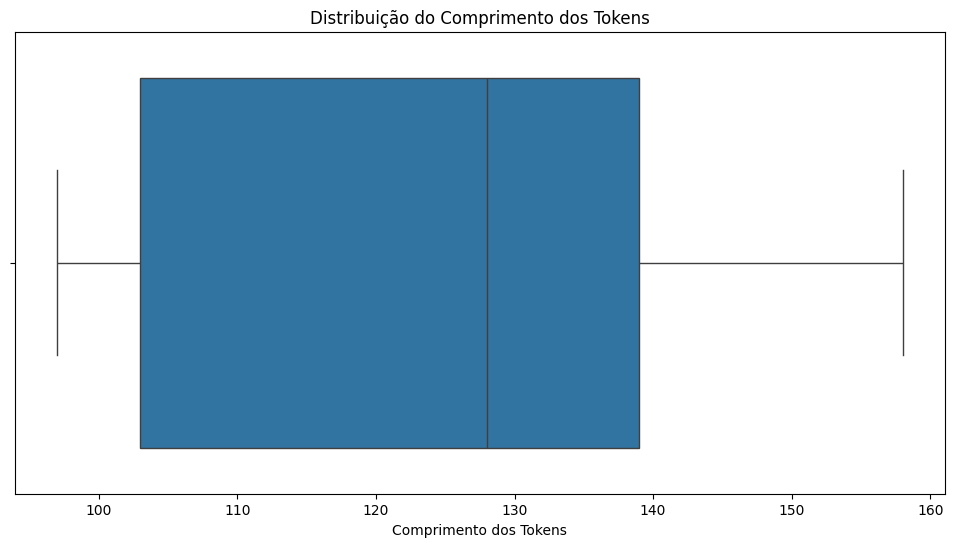

In [ ]:
# Passo 7: Análise do Comprimento dos Tokens

# Definir o comprimento máximo dos tokens
MAX_SEQ_LENGTH = 160

# Calculando o comprimento dos tokens
df_combined["formatted_instruction_tok_len"] = df_combined["formatted_instruction"].apply(
    lambda x: len(tokenizer.encode(x))
)

# Visualizando a distribuição do comprimento dos tokens
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_combined["formatted_instruction_tok_len"])
plt.xlabel("Comprimento dos Tokens")
plt.title("Distribuição do Comprimento dos Tokens")
plt.show()

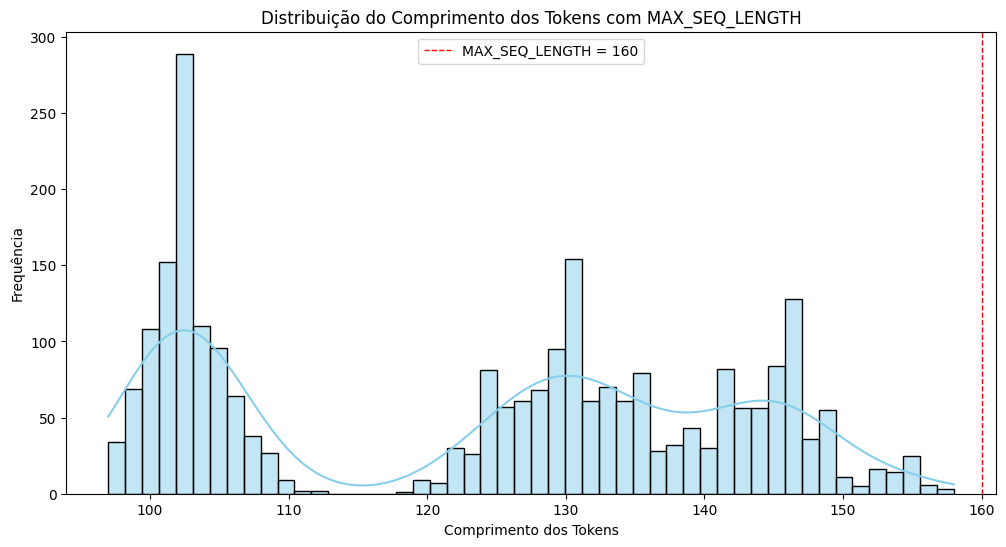


Dataset após filtrar tokens > 160: (2570, 4)


In [ ]:
# Passo 8: Definição do Comprimento Máximo dos Tokens e Filtragem dos Dados

# Visualizar a distribuição com a linha do MAX_SEQ_LENGTH
plt.figure(figsize=(12, 6))
sns.histplot(df_combined["formatted_instruction_tok_len"], bins=50, kde=True, color='skyblue')
plt.axvline(MAX_SEQ_LENGTH, color='red', linestyle='dashed', linewidth=1, label=f'MAX_SEQ_LENGTH = {MAX_SEQ_LENGTH}')
plt.xlabel("Comprimento dos Tokens")
plt.ylabel("Frequência")
plt.title("Distribuição do Comprimento dos Tokens com MAX_SEQ_LENGTH")
plt.legend()
plt.show()

# Filtragem dos Dados com Comprimento Máximo
df_filtered = df_combined[df_combined["formatted_instruction_tok_len"] <= MAX_SEQ_LENGTH]
print("\nDataset após filtrar tokens > 160:", df_filtered.shape)

In [ ]:
# Passo 9: Divisão do Dataset em Treinamento e Teste
RANDOM_SEED = 42
train_df, test_df = train_test_split(
    df_filtered,
    test_size=0.2,  # 20% para teste
    random_state=RANDOM_SEED,
    shuffle=True,
)

print("\nConjunto de Treinamento:", train_df.shape)
print("Conjunto de Teste:", test_df.shape)

# Opcional: Resetar os índices para evitar conflitos posteriores
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


Conjunto de Treinamento: (2056, 4)
Conjunto de Teste: (514, 4)


In [ ]:
# Passo 10: Converter DataFrames para Datasets do Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Criar um DatasetDict para facilitar o acesso
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print("\nDatasetDict:", dataset_dict)


DatasetDict: DatasetDict({
    train: Dataset({
        features: ['Instructions', 'Responses', 'formatted_instruction', 'formatted_instruction_tok_len'],
        num_rows: 2056
    })
    test: Dataset({
        features: ['Instructions', 'Responses', 'formatted_instruction', 'formatted_instruction_tok_len'],
        num_rows: 514
    })
})


In [ ]:
# Passo 12: Salvando o DataFrame de Teste
test_df.to_csv('test_dataset.csv', sep=';', index=False)
print("DataFrame de Teste salvo como 'test_dataset.csv'.")

DataFrame de Teste salvo como 'test_dataset.csv'.


In [ ]:
test_df = pd.read_csv('test_dataset.csv', sep=';')
test_df.head()

,Instructions,Responses,formatted_instruction,formatted_instruction_tok_len
0,"In the match Fortaleza vs Atlético Goianiense, the team Fortaleza had 60%% ball possession, 12 total shots, 3 shots on target, pass accuracy of 0%%, 5 corner kicks and committed 12 fouls. How was the team's overall performance?","The Fortaleza had a below-expected performance, with limited ball possession of only 60%%. The team created few goal opportunities, reflected in the 3 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match.","### Instruction:\nIn the match Fortaleza vs Atlético Goianiense, the team Fortaleza had 60%% ball possession, 12 total shots, 3 shots on target, pass accuracy of 0%%, 5 corner kicks and committed 12 fouls. How was the team's overall performance?\n\n### Response:\nThe Fortaleza had a below-expected performance, with limited ball possession of only 60%%. The team created few goal opportunities, reflected in the 3 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match.",149
1,"In the match Bahia vs Vasco, the team Vasco had 37%% ball possession, 9 total shots, 3 shots on target, pass accuracy of 0%%, 0 corner kicks and committed 15 fouls. How was the team's overall performance?","The Vasco had a below-expected performance, with limited ball possession of only 37%%. The team created few goal opportunities, reflected in the 3 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match.","### Instruction:\nIn the match Bahia vs Vasco, the team Vasco had 37%% ball possession, 9 total shots, 3 shots on target, pass accuracy of 0%%, 0 corner kicks and committed 15 fouls. How was the team's overall performance?\n\n### Response:\nThe Vasco had a below-expected performance, with limited ball possession of only 37%%. The team created few goal opportunities, reflected in the 3 shots on target, and faced difficulties in maintaining pass accuracy with 0%%. These factors contributed to an unsatisfactory performance in the match.",141
2,"In the match between Flamengo vs São Paulo, the player Agustín Rossi, playing as a goalkeeper made 2 saves, prevented 0.0 goals, and made 2 high claims. The average for players in this position was 2.0 saves, 0.0 prevented goals, and 2.0 high claims. Taking this into account, how was his performance?",His performance was good,"### Instruction:\nIn the match between Flamengo vs São Paulo, the player Agustín Rossi, playing as a goalkeeper made 2 saves, prevented 0.0 goals, and made 2 high claims. The average for players in this position was 2.0 saves, 0.0 prevented goals, and 2.0 high claims. Taking this into account, how was his performance?\n\n### Response:\nHis performance was good",103
3,"In the match between Atlético Mineiro vs Criciúma, the player Mauricio Lemos, playing as a defender made 1 tackles, 1 clearances, and 1 interceptions. The average for players in this position was 3.0 tackles, 3.5 clearances, and 1.2 interceptions. Taking this into account, how was his performance?",His performance was average,"### Instruction:\nIn the match between Atlético Mineiro vs Criciúma, the player Mauricio Lemos, playing as a defender made 1 tackles, 1 clearances, and 1 interceptions. The average for players in this position was 3.0 tackles, 3.5 clearances, and 1.2 interceptions. Taking this into account, how was his performance?\n\n### Response:\nHis performance was average",104
4,"In the match between Vitória and Botafogo, Raúl Cáceres, a defender from Vitória, had the following stats: Totaltackle: 4, Totalclearance: 1, Interceptionwon: 0. On the other hand, Wagner Leonardo, a defender from Vitória, had the following stats: Totaltackle: 3, Totalclearance: 5, Interceptionwon: 2. Based on these statistics, who had a better performa

In [ ]:
# Passo 1: Importação de Bibliotecas para Cálculo de Métricas
from transformers import StoppingCriteria, StoppingCriteriaList
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bertscore
from tqdm import tqdm  # Para barras de progresso
import pandas as pd

In [ ]:
# Passo 2: Definição da Classe StopOnTokens
class StopOnTokens(StoppingCriteria):
    def __init__(self, stop_token_ids):
        self.stop_token_ids = stop_token_ids

    def __call__(self, input_ids, scores, **kwargs):
        # Verifica se os últimos tokens correspondem à sequência de parada
        if len(input_ids[0]) >= len(self.stop_token_ids):
            if (input_ids[0][-len(self.stop_token_ids):] == self.stop_token_ids).all():
                return True
        return False

In [ ]:
# Passo 3: Função para Gerar Respostas com Stopping Criteria
def generate_response_with_stop(prompt, max_new_tokens=150, stop_sequence="### Instruction:"):
    """
    Gera uma resposta para um dado prompt usando o modelo com Stopping Criteria.

    Args:
        prompt (str): A instrução ou pergunta para o modelo.
        max_new_tokens (int): Número máximo de tokens a serem gerados na resposta.
        stop_sequence (str): Sequência que, ao ser gerada, interrompe a geração.

    Returns:
        str: A resposta gerada pelo modelo.
    """
    # Codificar o prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(model.device)

    # Codificar a sequência de parada
    stop_token_ids = tokenizer.encode(stop_sequence, add_special_tokens=False)

    # Definir os critérios de parada
    stopping_criteria = StoppingCriteriaList([StopOnTokens(torch.tensor(stop_token_ids).to(model.device))])

    # Gerar a resposta
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            stopping_criteria=stopping_criteria,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    # Decodificar a resposta gerada
    generated_text = tokenizer.decode(generation_output[0], skip_special_tokens=True)

    # Extrair apenas a parte gerada após o prompt
    generated = generated_text[len(prompt):].strip()

    # Remover a sequência de parada, se presente
    if stop_sequence in generated:
        generated = generated.split(stop_sequence)[0].strip()

    return generated


In [ ]:
# Passo 4: Gerar Respostas para o Conjunto de Teste

# Definir o número de amostras para avaliação (ajuste conforme necessário)
num_samples = 50  # Por exemplo, 50 amostras

# Selecionar aleatoriamente num_samples exemplos do conjunto de teste
test_df_sampled = test_df.sample(n=num_samples, random_state=42).reset_index(drop=True)

# Lista para armazenar as respostas geradas e as respostas reais
generated_responses = []
real_responses = []

# Definir a sequência de parada
stop_sequence = "### Instruction:"

# Gerar as respostas
for idx, row in tqdm(test_df_sampled.iterrows(), total=len(test_df_sampled)):
    prompt = f"### Instruction:\n{row['Instructions']}\n\n### Response:\n"
    real_response = row['Responses']

    # Gerar a resposta com a função definida
    generated = generate_response_with_stop(prompt, max_new_tokens=150, stop_sequence=stop_sequence)

    # Armazenar as respostas
    generated_responses.append(generated)
    real_responses.append(real_response)

    # Exibir alguns exemplos (opcional)
    if idx < 3:  # Exibir os primeiros 3 exemplos
        print(f"### Exemplo {idx+1}")
        print(f"Instrução:\n{row['Instructions']}")
        print(f"Resposta Real:\n{real_response}")
        print(f"Resposta Gerada:\n{generated}")
        print("-" * 50)


  2%|▏         | 1/50 [00:11<09:15, 11.35s/it]

### Exemplo 1
Instrução:
In the match between Atlético Mineiro vs Cuiabá, the player Walter, playing as a goalkeeper made 3 saves, prevented 0.2 goals, and made 3 high claims. The average for players in this position was 3.5 saves, 0.4 prevented goals, and 2.0 high claims. Taking this into account, how was his performance?
Resposta Real:
His performance was good
Resposta Gerada:
His performance was good.
--------------------------------------------------


  4%|▍         | 2/50 [00:22<09:03, 11.33s/it]

### Exemplo 2
Instrução:
In the match between Palmeiras and Criciúma, Raphael Veiga, a midfield from Palmeiras, had the following stats: Accuratepass: 16, Keypass: 1, Goalassist: 0. On the other hand, Fellipe Mateus, a midfield from Criciúma, had the following stats: Accuratepass: 15, Keypass: 1, Goalassist: 0. Based on these statistics, who had a better performance?
Resposta Real:
Raphael Veiga had a better performance.
Resposta Gerada:
Both players had similar performances.
--------------------------------------------------


  6%|▌         | 3/50 [00:33<08:52, 11.33s/it]

### Exemplo 3
Instrução:
In the match between Fortaleza vs Vitória, the player Breno Lopes, playing as a midfield had 21 accurate passes, created 1 key chances, and provided 1 assists. The average for players in this position was 21.0 accurate passes, 1.0 key chances, and 1.0 assists. Taking this into account, how was his performance?
Resposta Real:
His performance was great
Resposta Gerada:
His performance was good.
--------------------------------------------------


100%|██████████| 50/50 [09:26<00:00, 11.34s/it]


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import openai
openai.api_key = "sk-aUS4r40Excs7t5Apz9y10qtJya1HFjw_E6s5Bi_6uhT3BlbkFJ6jxFeK67_sVAsxu-feKIz9oDPzto6_IG4KA9cmz8AA"

# Passo 13: Definir função de avaliação com GPT-4
def evaluate_with_gpt4(question, prediction, reference, model="gpt-4", max_tokens=10):
    """
    Avalia a qualidade da resposta do modelo usando o GPT-4.

    Args:
        question (str): Pergunta original.
        prediction (str): Resposta gerada pelo modelo.
        reference (str): Resposta de referência.
        model (str): Modelo da OpenAI a ser usado. Padrão: "gpt-4".
        max_tokens (int): Número máximo de tokens para a resposta. Padrão: 10.

    Returns:
        float: Pontuação entre 0 e 1.
    """
    prompt = f"""
Compare as duas respostas a seguir para a pergunta dada e forneça uma pontuação entre 0 e 1 com base em sua qualidade, onde 1 é idêntica e 0 é completamente diferente. Avalie se a resposta é compatível com o contexto solicitado (por exemplo, se avalia desempenho) e se a avaliação dada está correta. Considere o significado e a intenção principal da pergunta, mesmo que palavras com significados semelhantes sejam usadas de forma diferente.

Contexto e Pergunta:
{question}

Resposta de Referência:
{reference}

Resposta do Modelo:
{prediction}

Pontuação:
"""

    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": "Você é um assistente útil."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=0,  # Para respostas determinísticas
            top_p=1,
            n=1,
            stop=None
        )
        score_text = response.choices[0].message['content'].strip()
        # Converter a resposta para float
        score = float(score_text)
        # Garantir que a pontuação esteja entre 0 e 1
        score = max(0.0, min(1.0, score))
    except Exception as e:
        print(f"Erro ao avaliar com GPT-4: {e}")
        score = 0.0  # Ou outro valor padrão apropriado

    return score


In [ ]:
# Passo 5: Cálculo das Métricas de Desempenho

# Inicializar o suavizador para BLEU
smoothie = SmoothingFunction().method4

# Inicializar o scorer para ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calcular BLEU scores
bleu_scores = []
for ref, pred in zip(real_responses, generated_responses):
    reference = [nltk.word_tokenize(ref.lower())]
    candidate = nltk.word_tokenize(pred.lower())
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    bleu_scores.append(score)

avg_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {avg_bleu:.4f}")

# Calcular ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for ref, pred in zip(real_responses, generated_responses):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"Average ROUGE-1 F1 Score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F1 Score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F1 Score: {avg_rougeL:.4f}")

# Calcular BERTScore
P, R, F1 = bertscore(generated_responses, real_responses, lang='en', rescale_with_baseline=True)

avg_bert_precision = P.mean().item()
avg_bert_recall = R.mean().item()
avg_bert_f1 = F1.mean().item()

print(f"Average BERTScore Precision: {avg_bert_precision:.4f}")
print(f"Average BERTScore Recall: {avg_bert_recall:.4f}")
print(f"Average BERTScore F1: {avg_bert_f1:.4f}")

Average BLEU Score: 0.7220
Average ROUGE-1 F1 Score: 0.8613
Average ROUGE-2 F1 Score: 0.8318
Average ROUGE-L F1 Score: 0.8613


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore Precision: 0.8342
Average BERTScore Recall: 0.8859
Average BERTScore F1: 0.8582


In [ ]:
# Passo 14: Atualizar a Função para Calcular Métricas Automáticas
def calculate_metrics(generated_responses, real_responses, questions=None):
    """
    Calcula as métricas BLEU, ROUGE, BERTScore, METEOR e GPT-4 entre as respostas geradas e as respostas reais.

    Args:
        generated_responses (list): Lista de respostas geradas pelo modelo.
        real_responses (list): Lista de respostas reais do conjunto de teste.
        questions (list, opcional): Lista de perguntas originais. Necessário para GPT-4.

    Returns:
        dict: Dicionário com as métricas calculadas.
    """
    # Inicializar os avaliadores
    bleu = evaluate.load('bleu')
    rouge = evaluate.load('rouge')
    meteor = evaluate.load('meteor')

    # Inicializar o suavizador para BLEU
    smoothie = SmoothingFunction().method4

    # Inicializar o scorer para ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Inicializar listas para armazenar as métricas
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bert_precision_scores = []
    bert_recall_scores = []
    bert_f1_scores = []
    meteor_scores = []
    gpt4_scores = []

    # Calcular BLEU, ROUGE, BERTScore e METEOR
    for ref, pred in zip(real_responses, generated_responses):
        # BLEU Score
        reference = [nltk.word_tokenize(ref.lower())]
        candidate = nltk.word_tokenize(pred.lower())
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
        bleu_scores.append(bleu_score)

        # ROUGE Scores
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

        # BERTScore
        P, R, F1 = bertscore([pred], [ref], lang='en', rescale_with_baseline=True)
        bert_precision_scores.append(P[0].item())
        bert_recall_scores.append(R[0].item())
        bert_f1_scores.append(F1[0].item())

        # METEOR Score
        meteor_score = meteor.compute(predictions=[pred], references=[ref])['meteor']
        meteor_scores.append(meteor_score)

    # Calcular BERTScore em lote para eficiência
    # (Alternativamente, pode ser calculado dentro do loop acima)

    # Calcular GPT-4 Scores se as perguntas forem fornecidas
    if questions:
        for question, ref, pred in zip(questions, real_responses, generated_responses):
            gpt4_score = evaluate_with_gpt4(question, pred, ref)
            gpt4_scores.append(gpt4_score)

    # Calcular as médias
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0
    avg_bert_precision = sum(bert_precision_scores) / len(bert_precision_scores) if bert_precision_scores else 0
    avg_bert_recall = sum(bert_recall_scores) / len(bert_recall_scores) if bert_recall_scores else 0
    avg_bert_f1 = sum(bert_f1_scores) / len(bert_f1_scores) if bert_f1_scores else 0
    avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    avg_gpt4 = sum(gpt4_scores) / len(gpt4_scores) if gpt4_scores else 0

    return {
        'Average BLEU Score': avg_bleu,
        'Average ROUGE-1 F1 Score': avg_rouge1,
        'Average ROUGE-2 F1 Score': avg_rouge2,
        'Average ROUGE-L F1 Score': avg_rougeL,
        'Average BERTScore Precision': avg_bert_precision,
        'Average BERTScore Recall': avg_bert_recall,
        'Average BERTScore F1': avg_bert_f1,
        'Average METEOR Score': avg_meteor,
        'Average GPT-4 Score': avg_gpt4,
    }


In [ ]:
# Passo 15: Atualizar a Função para Testar o Modelo com Métricas
def test_model_performance(test_df, num_samples=50):
    """
    Testa o desempenho do modelo no conjunto de teste, calculando métricas de avaliação.

    Args:
        test_df (pd.DataFrame): DataFrame do conjunto de teste.
        num_samples (int): Número de amostras a serem avaliadas.

    Returns:
        dict: Dicionário com as métricas calculadas.
        pd.DataFrame: DataFrame amostrado do conjunto de teste.
        list: Lista de respostas geradas.
        list: Lista de respostas reais.
    """
    # Selecionar aleatoriamente num_samples exemplos do conjunto de teste
    test_df_sampled = test_df.sample(n=num_samples, random_state=42).reset_index(drop=True)

    # Listas para armazenar as respostas geradas, reais e as perguntas
    generated_responses = []
    real_responses = []
    questions = []

    # Definir a sequência de parada
    stop_sequence = "### Instruction:"

    # Gerar as respostas
    for idx, row in tqdm(test_df_sampled.iterrows(), total=len(test_df_sampled)):
        prompt = f"### Instruction:\n{row['Instructions']}\n\n### Response:\n"
        real_response = row['Responses']
        question = row['Instructions']

        # Gerar a resposta com a função definida
        generated = generate_response_with_stop(prompt, max_new_tokens=150, stop_sequence=stop_sequence)

        # Armazenar as respostas e a pergunta
        generated_responses.append(generated)
        real_responses.append(real_response)
        questions.append(question)

        # Exibir alguns exemplos (opcional)
        if idx < 3:  # Exibir os primeiros 3 exemplos
            print(f"### Exemplo {idx+1}")
            print(f"Instrução:\n{row['Instructions']}")
            print(f"Resposta Real:\n{real_response}")
            print(f"Resposta Gerada:\n{generated}")
            print("-" * 50)

    # Calcular as métricas
    metrics = calculate_metrics(generated_responses, real_responses, questions)

    return metrics, test_df_sampled, generated_responses, real_responses


In [ ]:
# Passo 16: Executar a Função de Teste e Exibir as Métricas
metrics, sampled_test_df, generated_responses, real_responses = test_model_performance(test_df, num_samples=50)

# Exibir as métricas
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

  2%|▏         | 1/50 [00:11<09:42, 11.90s/it]

### Exemplo 1
Instrução:
In the match between Atlético Mineiro vs Cuiabá, the player Walter, playing as a goalkeeper made 3 saves, prevented 0.2 goals, and made 3 high claims. The average for players in this position was 3.5 saves, 0.4 prevented goals, and 2.0 high claims. Taking this into account, how was his performance?
Resposta Real:
His performance was good
Resposta Gerada:
His performance was good.

### Explanation:
Walter had a good performance, making 3 saves, preventing 0.2 goals, and making 3 high claims. The average for players in this position was 3.5 saves, 0.4 prevented goals, and 2.0 high claims. Based on these statistics, Walter had a good performance.
--------------------------------------------------


  4%|▍         | 2/50 [00:23<09:16, 11.60s/it]

### Exemplo 2
Instrução:
In the match between Palmeiras and Criciúma, Raphael Veiga, a midfield from Palmeiras, had the following stats: Accuratepass: 16, Keypass: 1, Goalassist: 0. On the other hand, Fellipe Mateus, a midfield from Criciúma, had the following stats: Accuratepass: 15, Keypass: 1, Goalassist: 0. Based on these statistics, who had a better performance?
Resposta Real:
Raphael Veiga had a better performance.
Resposta Gerada:
Both players had similar performances.
--------------------------------------------------


  6%|▌         | 3/50 [00:34<09:01, 11.52s/it]

### Exemplo 3
Instrução:
In the match between Fortaleza vs Vitória, the player Breno Lopes, playing as a midfield had 21 accurate passes, created 1 key chances, and provided 1 assists. The average for players in this position was 21.0 accurate passes, 1.0 key chances, and 1.0 assists. Taking this into account, how was his performance?
Resposta Real:
His performance was great
Resposta Gerada:
His performance was good.
--------------------------------------------------


100%|██████████| 50/50 [09:28<00:00, 11.38s/it]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.w

Average BLEU Score: 0.7405
Average ROUGE-1 F1 Score: 0.8762
Average ROUGE-2 F1 Score: 0.8481
Average ROUGE-L F1 Score: 0.8762
Average BERTScore Precision: 0.8536
Average BERTScore Recall: 0.8980
Average BERTScore F1: 0.8740
Average METEOR Score: 0.8761
Average GPT-4 Score: 0.9160


<ipython-input-32-078e40e900f0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette='viridis')


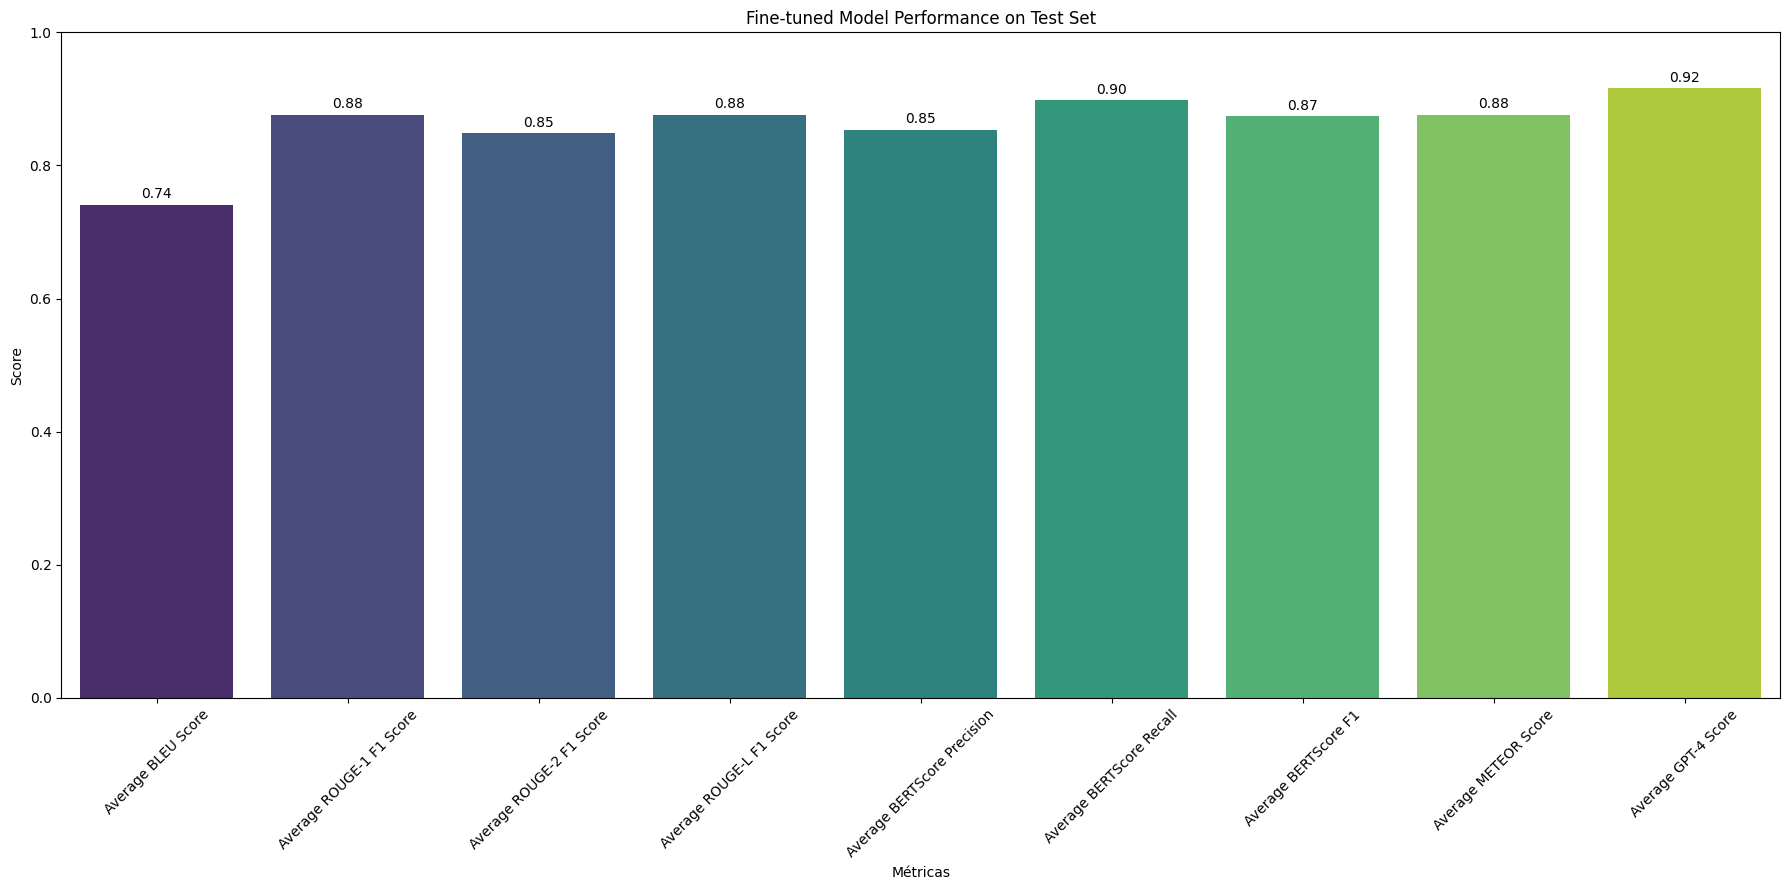

In [ ]:
# Passo 17: Visualização das Métricas Atualizada

import matplotlib.pyplot as plt

# Extrair as métricas
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plotar as métricas
plt.figure(figsize=(18, 9))  # Aumentar o tamanho para acomodar mais métricas
sns.barplot(x=metric_names, y=metric_values, palette='viridis')
plt.ylabel('Score')
plt.xlabel('Métricas')
plt.title('Fine-tuned Model Performance on Test Set')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # As métricas estão entre 0 e 1
for index, value in enumerate(metric_values):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.tight_layout()
plt.show()

<ipython-input-44-87175f96e3cf>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette='viridis')


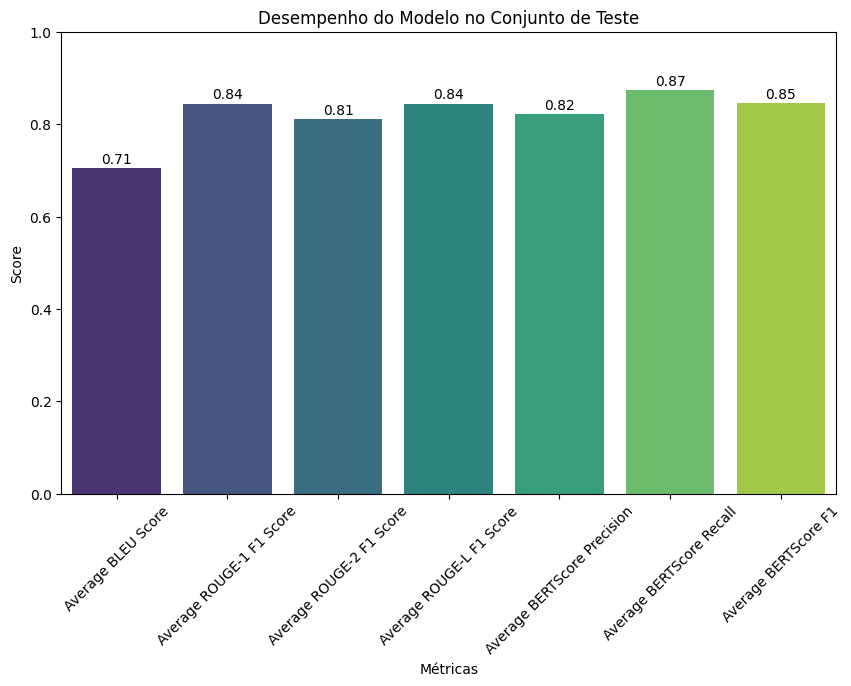

In [ ]:
# Passo 10: Visualização das Métricas (anterior)

import matplotlib.pyplot as plt

# Extrair as métricas
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plotar as métricas
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_names, y=metric_values, palette='viridis')
plt.ylabel('Score')
plt.xlabel('Métricas')
plt.title('Desempenho do Modelo no Conjunto de Teste')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # As métricas estão entre 0 e 1
for index, value in enumerate(metric_values):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()


In [ ]:
# Passo 11: Salvando os Resultados das Métricas e Respostas Geradas

# Criar um DataFrame com as respostas geradas e reais
results_df = pd.DataFrame({
    'Instructions': sampled_test_df['Instructions'],
    'Real Responses': real_responses,
    'Generated Responses': generated_responses
})

# Salvar as respostas em um arquivo CSV
results_df.to_csv('model_performance_results.csv', sep=';', index=False)
print("Resultados das métricas e respostas geradas salvos em 'model_performance_results.csv'.")


Resultados das métricas e respostas geradas salvos em 'model_performance_results.csv'.


In [ ]:
# Passo 12: Análise Detalhada das Respostas Geradas

# Exibir os primeiros 5 exemplos
for i in range(5):
    print(f"### Exemplo {i+1}")
    print(f"Instrução:\n{sampled_test_df.loc[i, 'Instructions']}")
    print(f"Resposta Real:\n{real_responses[i]}")
    print(f"Resposta Gerada:\n{generated_responses[i]}")
    print("-" * 50)


### Exemplo 1
Instrução:
In the match between Atlético Mineiro vs Cuiabá, the player Walter, playing as a goalkeeper made 3 saves, prevented 0.2 goals, and made 3 high claims. The average for players in this position was 3.5 saves, 0.4 prevented goals, and 2.0 high claims. Taking this into account, how was his performance?
Resposta Real:
His performance was good
Resposta Gerada:
His performance was average.
--------------------------------------------------
### Exemplo 2
Instrução:
In the match between Palmeiras and Criciúma, Raphael Veiga, a midfield from Palmeiras, had the following stats: Accuratepass: 16, Keypass: 1, Goalassist: 0. On the other hand, Fellipe Mateus, a midfield from Criciúma, had the following stats: Accuratepass: 15, Keypass: 1, Goalassist: 0. Based on these statistics, who had a better performance?
Resposta Real:
Raphael Veiga had a better performance.
Resposta Gerada:
Both players had similar performances.
--------------------------------------------------
### Ex